## Quora question pair similarity, you need to find the Similarity between two questions by mapping the words in the questions using TF-IDF, and using a supervised Algorithm you need to find the similarity between the questions.

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Loading Training and Test dataset

df_train = pd.read_csv('Data/quora-question-pairs/train/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
df_train.shape

(404290, 6)

In [4]:
df_test = pd.read_csv('Data/quora-question-pairs/test_zip/test_zip.csv')
df_test.head()

C:\Users\himz\AppData\Local\Temp\ipykernel_19264\2856470029.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('Data/quora-question-pairs/test_zip/test_zip.csv')


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
df_test.shape

(3563475, 3)

### Text Analysis

Text(0, 0.5, 'Probability')

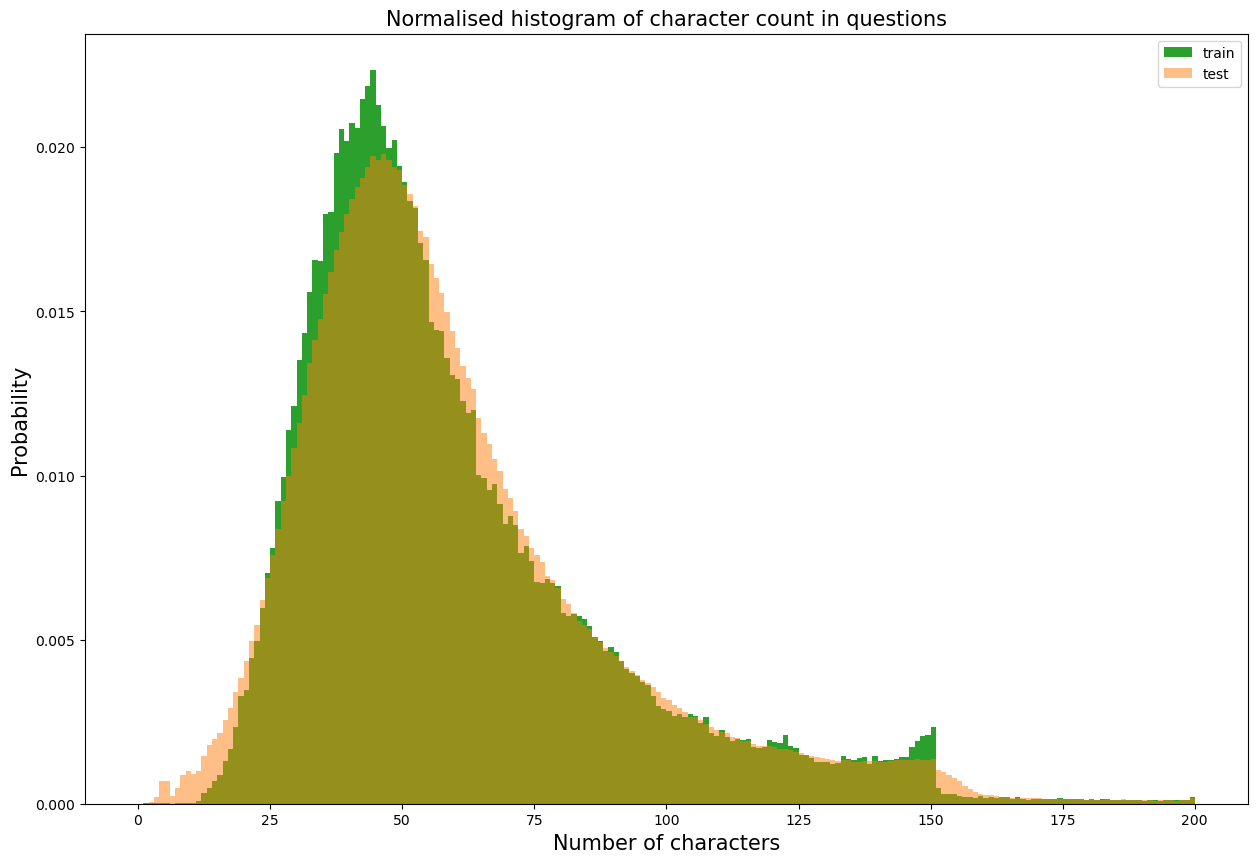

In [6]:
train_ques = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_ques = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_ques.apply(len)
dist_test = test_ques.apply(len)

pal = sns.color_palette()

# plotting
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], density=True, color=pal[2], label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

(-0.5, 1439.5, 1079.5, -0.5)

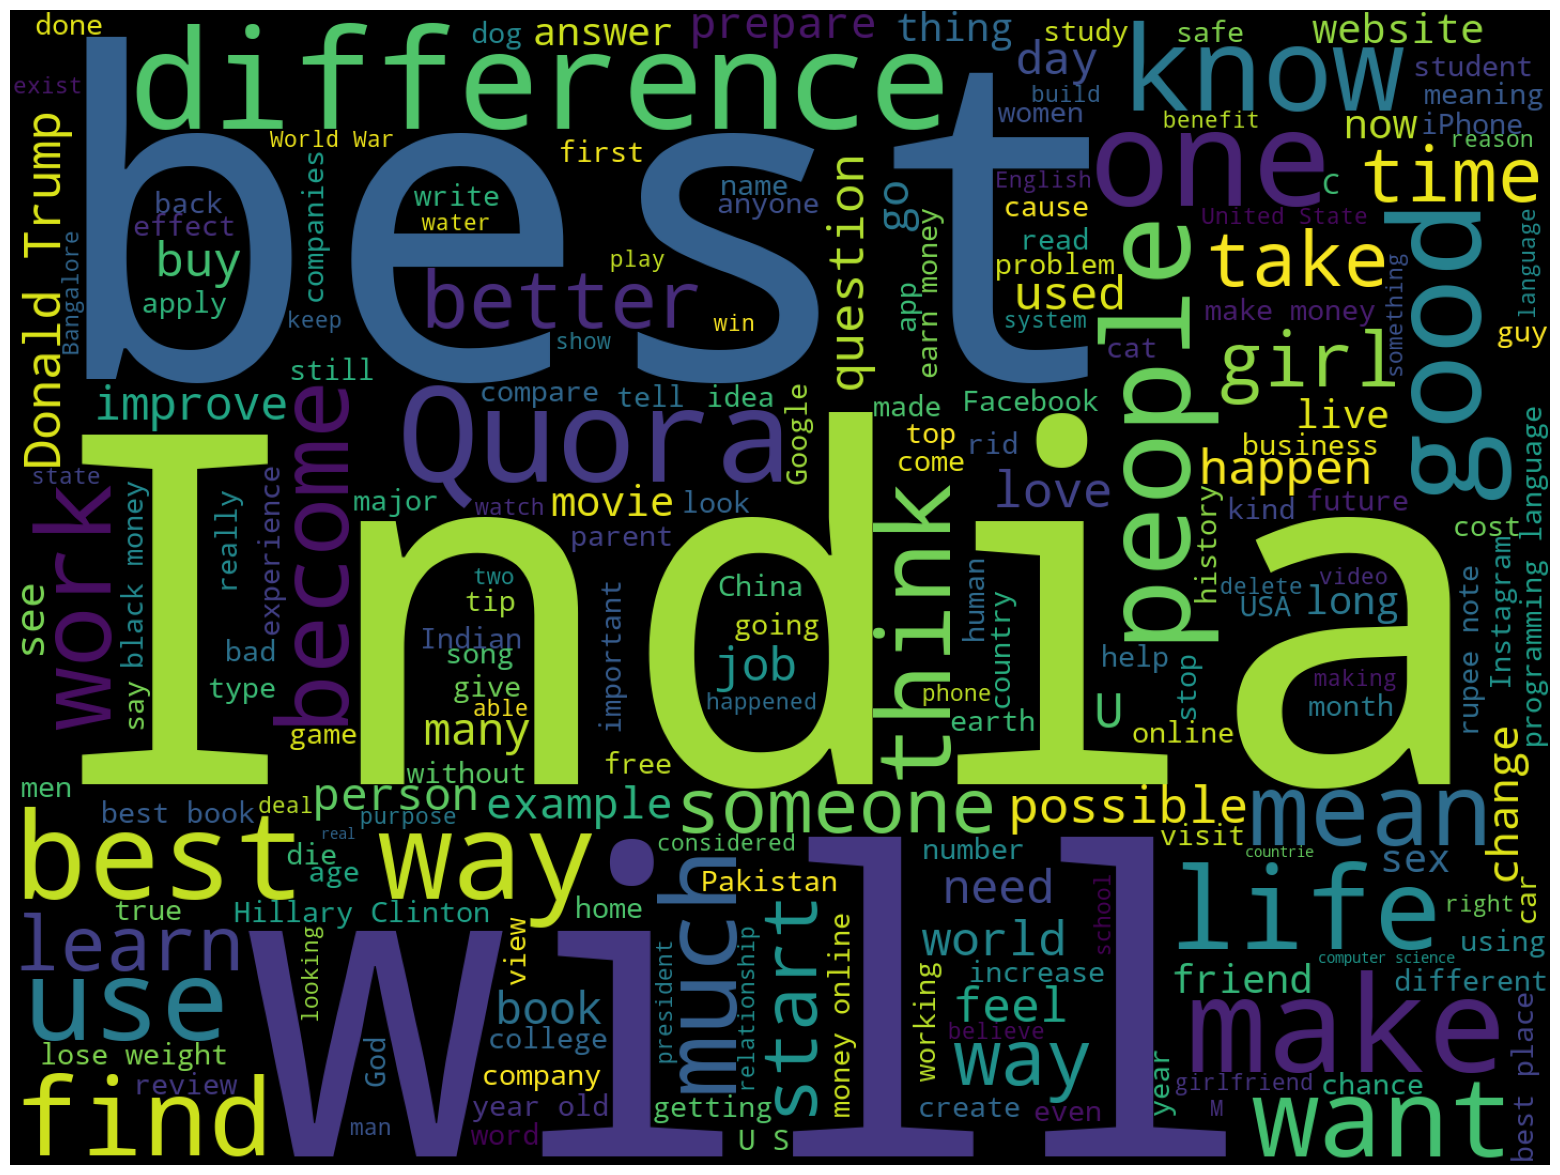

In [7]:
# Most common words

from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_ques.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

### Feature Analysis

In [8]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [9]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 0, 'word_match_share')

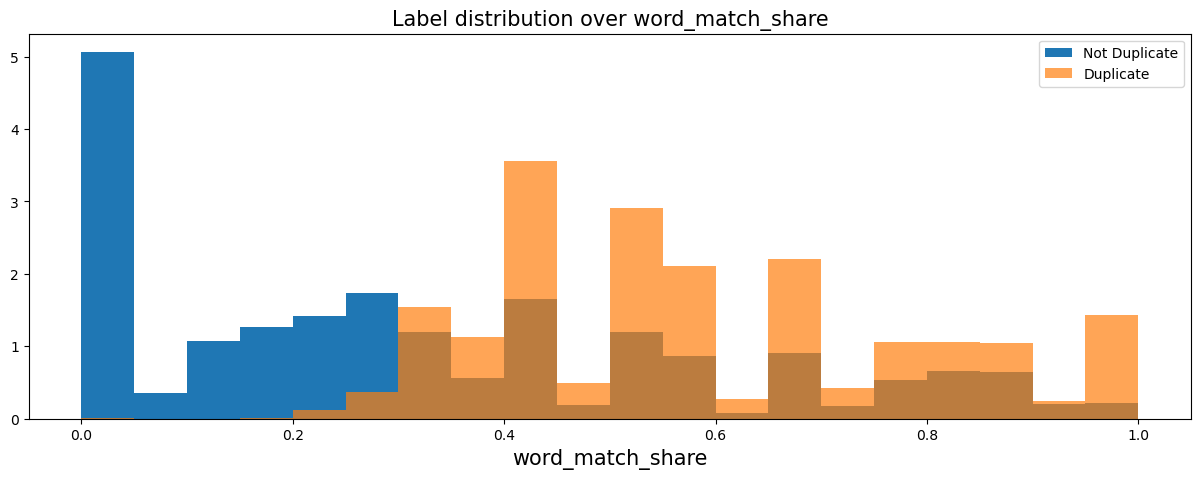

In [10]:
plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

### TF-IDF

In [11]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_ques)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [12]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R


C:\Users\himz\AppData\Local\Temp\ipykernel_19264\88074652.py:17: RuntimeWarning: invalid value encountered in scalar divide
  R = np.sum(shared_weights) / np.sum(total_weights)


Text(0.5, 0, 'word_match_share')

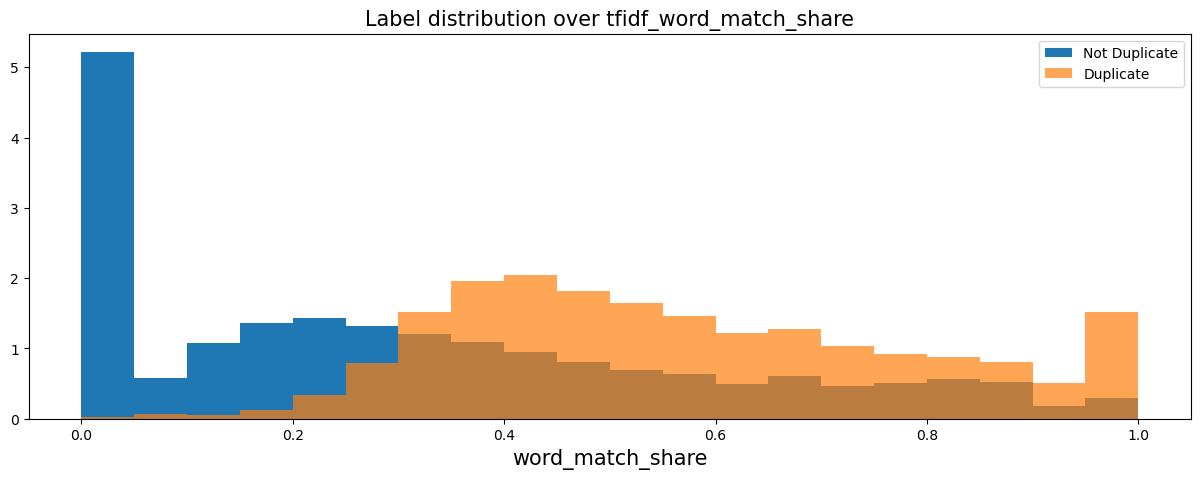

In [13]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, density=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [14]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804301261319899
   TFIDF AUC: 0.7704775333415721


### Data Prep

In [15]:
# Split the data into question pairs and labels
questions = df_train[['question1', 'question2']]
labels = df_train['is_duplicate']

In [18]:
questions_train, questions_test, labels_train, labels_test = train_test_split(questions, labels, test_size=0.2, random_state=42)

In [19]:
# Applying tfidf on train set
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(questions_train['question1'] + ' ' + questions_train['question2'])

### Model Trianing

In [20]:
model = LogisticRegression()
model.fit(tfidf_train, labels_train)

C:\Users\himz\miniconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
# Applying tfidf on test set
tfidf_test = tfidf.transform(questions_test['question1'] + ' ' + questions_test['question2'])
predictions = model.predict(tfidf_test)

### Evaluation

In [22]:
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7550273318657399
